# 前処理

In [1]:
!pip install --upgrade setuptools
!pip install --upgrade pip
!pip install  google-cloud-bigquery
!pip install pydata-google-auth
!pip install db-dtypes
!pip install networkx
!pip install matplotlib

In [7]:

import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

In [8]:
#BigQueryで加工済み(にじかホロのファンアートタグを含んでいた場合フラグ付し、フラグが付いたツイートのみ取得)のツイート一覧を取得

import json
from google.cloud import bigquery 

variables = open('variables.json' , 'r')
variables = json.load(variables)

client = bigquery.Client(project=variables['bq_project_name'], credentials=credentials)
query = 'SELECT * FROM '+variables['bq_table_name']+' WHERE DATE(created_at, "Japan") BETWEEN "2021-11-22" AND "2022-11-21"'
df_tmp = client.query(query).to_dataframe()
df = df_tmp

In [9]:
df.head()

,quoted_id,quoted_status_id_str,in_reply_to_status_id,quote_count,timestamp_ms,possibly_sensitive,favorited,user_id,created_at,id_str,...,quoted_status_id,in_reply_to_user_id,retweeted_id,lang,retweet_count,in_reply_to_user_id_str,text,hololive_flg,nijisanji_flg,ix
0,<NA>,None,<NA>,0,1638374815657,False,False,1364925780870922241,2021-12-01 16:06:55+00:00,1466076353267003392,...,<NA>,<NA>,<NA>,ja,0,None,イエイイエーイって感じのぺこーら描きました！\n#兎田ぺこら #ぺこらーと https://...,True,False,16632
1,<NA>,None,<NA>,0,1638375970659,False,False,70954558,2021-12-01 16:26:10+00:00,1466081197696909312,...,<NA>,<NA>,<NA>,ja,0,None,加賀美ハヤト社長、お誕生日おめでとうございます！！��������\n新たな一年も、素敵な日...,False,True,16633
2,<NA>,None,<NA>,0,1638498927660,False,False,721892949672366080,2021-12-03 02:35:27+00:00,1466596916738035713,...,<NA>,<NA>,<NA>,ja,0,None,にぇ\n#さくらみこ\n#miko_Art\n#みこちはエリート https://t.co/...,True,False,16661
3,<NA>,None,<NA>,0,1638657259660,False,False,1399838153557516292,2021-12-04 22:34:19+00:00,1467261009278558213,...,<NA>,<NA>,<NA>,ja,0,None,#ほしまちぎゃらりー ☆彡 ☆〜（ゝ。∂） https://t.co/jruhu3NkVD,True,False,16700
4,<NA>,None,<NA>,0,1638851863663,False,False,1455842042513268743,2021-12-07 04:37:43+00:00,1468077237627146240,...,<NA>,<NA>,<NA>,ja,0,None,親戚家のわんちゃん②\n#いぬいらすと #イラスト #アナログ絵 \n#トイプー #水彩画 ...,False,True,16761


In [10]:
# 各社のVTuberのファンアートタグと名前の対応表

import pandas as pd

df_tag_holo = pd.read_csv('tag_holo.csv')
df_tag_niji = pd.read_csv('tag_niji.csv')
df_tag_niji.head()

,name,tag,Twitter
0,月ノ美兎,#みとあーと,@MitoTsukino
1,勇気ちひろ,#ちーあーと,@Chihiro_yuki23
2,える,#えるの絵だよ,@Elu_World
3,樋口楓,#でろあーと,@HiguchiKaede
4,静凛,#凛Art,@ShizuRin23


In [42]:
dfs_tagged = []

for hako in ['niji', 'holo']:
    flg_name = 'nijisanji_flg' if hako == 'niji' else 'hololive_flg'
    df_tag = df_tag_niji if hako == 'niji' else df_tag_holo
    
    # df_taggedの初期化
    df_tagged = df[df[flg_name]==True][['user_id', 'created_at', 'text']]

    # タグのカラムをFalseで初期化
    for tag_name in df_tag['name'].unique():
        df_tagged[tag_name] = False

    for _, row in df_tag.iterrows():
        # 各タグが含まれているかチェックし、結果を蓄積
        df_tagged[row['name']] |= df_tagged['text'].str.contains(row['tag'])

    df_tagged.to_csv('tweets_tagged_'+hako+'.csv')
    
    dfs_tagged.append(df_tagged)

/var/folders/bd/l206qckj0ts_nk014r8kj4lm0000gn/T/ipykernel_1179/2222246832.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tagged[tag_name] = False
/var/folders/bd/l206qckj0ts_nk014r8kj4lm0000gn/T/ipykernel_1179/2222246832.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tagged[tag_name] = False
/var/folders/bd/l206qckj0ts_nk014r8kj4lm0000gn/T/ipykernel_1179/2222246832.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [44]:
dfs_tagged[0].head()

,user_id,created_at,text,月ノ美兎,勇気ちひろ,える,樋口楓,静凛,渋谷ハジメ,鈴谷アキ,...,ソフィア・ヴァレンタイン,倉持めると,佐伯イッテツ,赤城ウェン,宇佐美リト,緋八マナ,星導ショウ,叢雲カゲツ,小柳ロウ,伊波ライ
1,70954558,2021-12-01 16:26:10+00:00,加賀美ハヤト社長、お誕生日おめでとうございます！！��������\n新たな一年も、素敵な日...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1455842042513268743,2021-12-07 04:37:43+00:00,親戚家のわんちゃん②\n#いぬいらすと #イラスト #アナログ絵 \n#トイプー #水彩画 ...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,1468753168230404102,2021-12-16 13:38:15+00:00,#上弦画 \n\n描きたかったやつ〜！ https://t.co/MltIYBtnq1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13,1338056982624755713,2021-12-22 09:48:07+00:00,線画やっとできた\n#線画 #wip #葛葉 #KuzuArt #イラスト好きさんと繋が...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14,1342464767491903489,2021-12-24 13:48:01+00:00,3Dお披露目お疲れ様～！！！！\n伝えたいことをQRコードにしたのでよかったら見てね！！\n...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
import pandas as pd

dfs_tagged = []
dfs_tagged.append(pd.read_csv('tweets_tagged_niji.csv'))
dfs_tagged.append(pd.read_csv('tweets_tagged_holo.csv'))

# 投稿数ランキング

In [46]:
dfs_tagged[0].iloc[:, 3:].sum().reset_index().rename(columns={0:'cnt'}).sort_values('cnt', ascending=False).head(10)

,index,cnt
107,甲斐田晴,711
16,剣持刀也,528
24,葛葉,371
81,黛灰,317
18,叶,296
96,不破湊,288
70,三枝明那,272
119,壱百満天原サロメ,216
105,長尾景,189
14,伏見ガク,171


In [47]:
dfs_tagged[1].iloc[:, 3:].sum().reset_index().rename(columns={0:'cnt'}).sort_values('cnt', ascending=False).head(10)

,index,cnt
22,宝鐘マリン,268
36,沙花叉クロヱ,227
3,星街すいせい,218
16,猫又おかゆ,195
18,兎田ぺこら,195
8,白上フブキ,193
2,さくらみこ,177
17,戌神ころね,173
10,湊あくあ,152
28,雪花ラミィ,150


In [11]:
import pandas as pd

# 以下のコードは、複数のデータフレームがあることを前提としています。
# この例では、dfs_taggedというリストにデータフレームが格納されていると仮定しています。
dfs_cor = []

for i, df_tagged in enumerate(dfs_tagged):
    hako = 'niji' if i == 1 else 'holo'

    # キャラクターに関する列のみを抽出（ユーザーID、ツイート作成日、テキストを除外）
    character_data = df_tagged.drop(columns=['user_id', 'created_at', 'text'])

    # 共起マトリックスを初期化
    co_occurrence_matrix = pd.DataFrame(0, index=character_data.columns, columns=character_data.columns)

    # 各ツイートでタグ付けされたキャラクターの組み合わせをカウント
    for index, row in character_data.iterrows():
        tags = row[row == True].index
        for i in range(len(tags)):
            for j in range(i + 1, len(tags)):
                co_occurrence_matrix.at[tags[i], tags[j]] += 1
                co_occurrence_matrix.at[tags[j], tags[i]] += 1

    # 共起マトリックスをunpivotして共起回数のランキングを作成
    co_occurrence_unpivoted = co_occurrence_matrix.unstack().reset_index()
    co_occurrence_unpivoted.columns = ['Character1', 'Character2', 'CoOccurrenceCount']
    co_occurrence_unpivoted = co_occurrence_unpivoted[co_occurrence_unpivoted['Character1'] != co_occurrence_unpivoted['Character2']]
    co_occurrence_ranking = co_occurrence_unpivoted.sort_values(by='CoOccurrenceCount', ascending=False)

    # Character1とCharacter2が同じ組み合わせのものをまとめる
    co_occurrence_ranking['Pair'] = co_occurrence_ranking.apply(lambda x: tuple(sorted([x['Character1'], x['Character2']])), axis=1)
    combined_ranking = co_occurrence_ranking.groupby('Pair')['CoOccurrenceCount'].sum().sort_values(ascending=False).reset_index()

    # PairをCharacter1とCharacter2に分割し、共起回数を半分にする
    combined_ranking[['Character1', 'Character2']] = pd.DataFrame(combined_ranking['Pair'].tolist(), index=combined_ranking.index)
    combined_ranking['CoOccurrenceCount'] = combined_ranking['CoOccurrenceCount'] / 2

    combined_ranking.to_csv('co_occurrence_ranking_'+hako+'.csv')
        
    dfs_cor.append(combined_ranking)

In [12]:
dfs_cor[0].head(10)

,Pair,CoOccurrenceCount,Character1,Character2
0,"(三枝明那, 不破湊)",91.0,三枝明那,不破湊
1,"(叶, 葛葉)",85.0,叶,葛葉
2,"(三枝明那, 黛灰)",66.0,三枝明那,黛灰
3,"(不破湊, 黛灰)",63.0,不破湊,黛灰
4,"(伏見ガク, 剣持刀也)",49.0,伏見ガク,剣持刀也
5,"(甲斐田晴, 長尾景)",37.0,甲斐田晴,長尾景
6,"(弦月藤士郎, 長尾景)",33.0,弦月藤士郎,長尾景
7,"(弦月藤士郎, 甲斐田晴)",32.0,弦月藤士郎,甲斐田晴
8,"(不破湊, 甲斐田晴)",32.0,不破湊,甲斐田晴
9,"(剣持刀也, 加賀美ハヤト)",29.0,剣持刀也,加賀美ハヤト


In [13]:
dfs_cor[1].head(10)

,Pair,CoOccurrenceCount,Character1,Character2
0,"(戌神ころね, 猫又おかゆ)",35.0,戌神ころね,猫又おかゆ
1,"(さくらみこ, 星街すいせい)",35.0,さくらみこ,星街すいせい
2,"(獅白ぼたん, 雪花ラミィ)",24.0,獅白ぼたん,雪花ラミィ
3,"(沙花叉クロヱ, 風真いろは)",24.0,沙花叉クロヱ,風真いろは
4,"(沙花叉クロヱ, 鷹嶺ルイ)",22.0,沙花叉クロヱ,鷹嶺ルイ
5,"(博衣こより, 沙花叉クロヱ)",20.0,博衣こより,沙花叉クロヱ
6,"(博衣こより, 風真いろは)",20.0,博衣こより,風真いろは
7,"(風真いろは, 鷹嶺ルイ)",18.0,風真いろは,鷹嶺ルイ
8,"(兎田ぺこら, 宝鐘マリン)",18.0,兎田ぺこら,宝鐘マリン
9,"(桃鈴ねね, 獅白ぼたん)",18.0,桃鈴ねね,獅白ぼたん


# ネットワーク指標
参考: https://blog.deepblue-ts.co.jp/network/python_networkx/

In [69]:
#ネットワークを作成
import networkx as nx
Gs = []

for df in dfs_cor:
    # numpyのarray型に変換
    network_np = df[['Character1', 'Character2', 'CoOccurrenceCount']].values

    # 空の無向グラフを作成
    G = nx.Graph()
    # 重み付きの枝を加える
    G.add_weighted_edges_from(network_np)

    # 重み2未満のエッジをリストアップ
    edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if w['weight'] < 2]

    # これらのエッジを削除
    for edge in edges_to_remove:
        G.remove_edge(*edge)

    Gs.append(G)

In [70]:
#ノード数
for G in Gs:
    print(nx.number_of_nodes(G))

140
44


In [71]:
#グラフの密度
for G in Gs:
    print(nx.density(G))

0.029496402877697843
0.24735729386892177


In [72]:
#各ノードの次数
for G in Gs:
    degrees = G.degree()

    # 次数をもとにリストを作成し、次数でソート
    sorted_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)

    # 結果を表示
    print(sorted_degrees)

[('健屋花那', 23), ('葛葉', 22), ('不破湊', 20), ('黛灰', 19), ('甲斐田晴', 19), ('イブラヒム', 19), ('叶', 16), ('椎名唯華', 16), ('本間ひまわり', 16), ('ジョー・力一', 16), ('剣持刀也', 15), ('セラフ・ダズルガーデン', 15), ('笹木咲', 15), ('天宮こころ', 15), ('勇気ちひろ', 15), ('加賀美ハヤト', 14), ('星川サラ', 14), ('レヴィ・エリファ', 13), ('ギルザレンIII世', 12), ('樋口楓', 12), ('ラトナ・プティ', 12), ('三枝明那', 11), ('社築', 11), ('物述有栖', 11), ('黒井しば', 11), ('空星きらめ', 11), ('アルス・アルマル', 10), ('戌亥とこ', 10), ('ベルモンド・バンデラス', 10), ('夜見れな', 8), ('花畑チャイカ', 8), ('伏見ガク', 7), ('相羽ういは', 7), ('緑仙', 6), ('葉加瀬冬雪', 5), ('魔界ノりりむ', 5), ('アンジュ・カトリーナ', 5), ('長尾景', 4), ('弦月藤士郎', 4), ('夕陽リリ', 4), ('月ノ美兎', 4), ('鷹宮リオン', 4), ('西園チグサ', 4), ('ドーラ', 4), ('シェリン・バーガンディ', 4), ('四季凪アキラ', 3), ('風楽奏斗', 3), ('卯月コウ', 3), ('渡会雲雀', 3), ('リゼ・ヘルエスタ', 3), ('メリッサ・キンレンカ', 3), ('グウェル・オス・ガール', 3), ('白雪巴', 3), ('でびでび・でびる', 3), ('夢追翔', 3), ('家長むぎ', 3), ('アクシア・クローネ', 3), ('フレン・E・ルスタリオ', 2), ('フミ', 2), ('魔使マオ', 2), ('山神カルタ', 2), ('早瀬走', 2), ('竜胆尊', 2), ('ニュイ・ソシエール', 2), ('エクス・アルビオ', 2), ('壱百満天原サロメ', 2), ('シスター・クレア', 2), ('静凛',

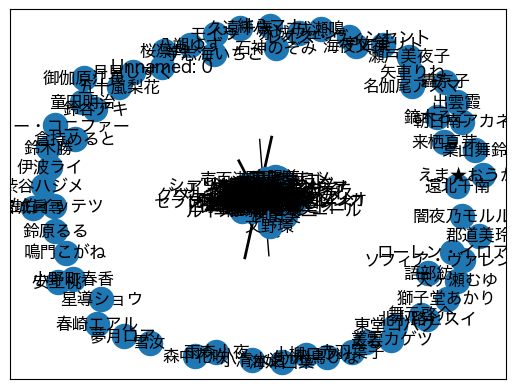

In [79]:
#グラフ
import matplotlib

# for G in Gs:
G = Gs[0]
weights = nx.get_edge_attributes(G, 'weight').values()
nx.draw_networkx(G, width = list(weights)*1000, font_family='Hiragino Sans')